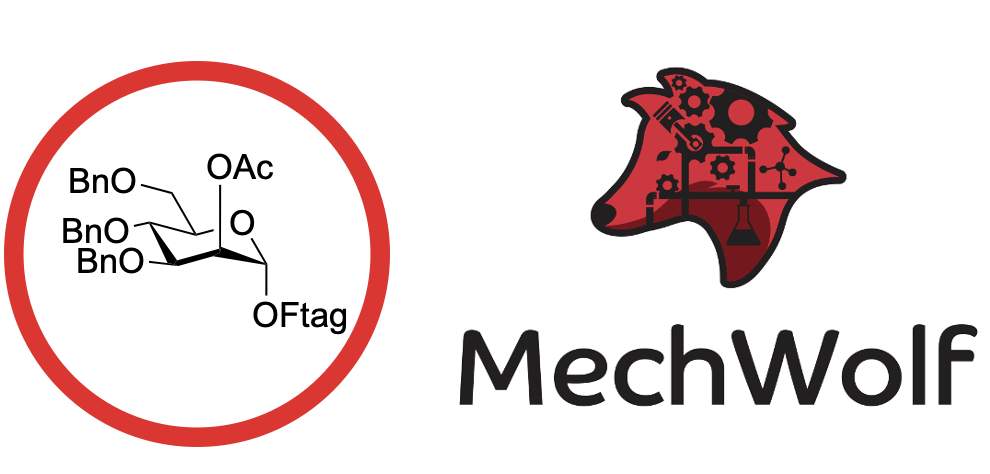

### Copyright information

Copyright <2023> NICOLA POHL
Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:
1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS “AS IS” AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
This code is based on Jupyter Notebooks.
Kluyver, T., Ragan-Kelley, B., Pérez, F., Granger, B.E., Bussonnier, M., Frederic, J., Kelley, K., Hamrick, J.B., Grout, J., Corlay, S., Ivanov, P., Avila, D., Abdalla, S., Willing, C., & Team, J.D. (2016). Jupyter Notebooks - a publishing format for reproducible computational workflows. International Conference on Electronic Publishing

### Ftag glycosylation to SCDVHQXHQOSKCS-GAEUMROQSA-N (One Pump)

This code calculates moles, describes a reaction setup, and controls syringe pumps. Comments in each cell will guide you to which parts generally need to be edited for each new reaction and which can stay the same. To run this code, click in the first cell and click 'Run' at the top left edge of the screen. While the cell is running, it will show an asterisk within brackets directly to its left In [*]. Once the cell has fi nished running, this asterisk will be replaced by a number. You must run each cell in order for the complete code to work. You can do these one at a time, or by clicking Cell --> run all

In [11]:
import mechwolf as mw
import graphviz
import math
from datetime import timedelta
from astropy.table import QTable, Table, Column
from sigfig import round
import json

### InChi Keys and Equivalents

Input reagent info here to automatically generate a table below. Mass scale refers to themass in grams of your limiting reagent. Concentration is in Mol/L. For each reagent, fill in therequired variables, making sure to put a comma after each until the closed brackets. To find the inChi code, select the structure in ChemDraw, right click, and select molecule > copy as> InChi. Alternatively, inChi codes for common structures can be found on Wikipedia or NIHPubChem directory. To add more reagents, copy and paste one {} block

In [12]:
data ={
   "mass scale": 0.1,
    "concentration": 0.100,
    "solvent": "DCM",
    "limiting reagent": "benzylated orthoester",
    "solid reagents": [
        {
            "name": "benzylated orthoester",
            "inChi": "InChI=1S/C30H34O7/c1-30(31-2)36-28-27(34-20-24-16-10-5-11-17-24)26(33-19-23-14-8-4-9-15-23)25(35-29(28)37-30)21-32-18-22-12-6-3-7-13-22/h3-17,25-29H,18-21H2,1-2H3/t25-,26?,27?,28+,29+,30?/m1/s1",
            "inChi Key": "SCDVHQXHQOSKCS-GAEUMROQSA-N",
            "molecular weight": 506,
            "eq": 1.0,
            "syringe": 1
        }
        
    ],
    "liquid reagents": [
        { "name": "BF3OEt2",
            "inChi": "1S/C4H9F3O3SSi/c1-12(2,3)10-11(8,9)4(5,6)7/h1-3H3",
            "inChi Key": "FTVLMFQEYACZNP-UHFFFAOYSA-N",
            "molecular weight": 222.26,
            "eq": 0.2,
            "density": 1.15,
            "syringe": 2
        },
        { "name": "ftag",
            "inChi": "1S/C4H9F3O3SSi/c1-12(2,3)10-11(8,9)4(5,6)7/h1-3H3",
            "inChi Key": "FTVLMFQEYACZNP-UHFFFAOYSA-N",
            "molecular weight": 448.12,
            "eq": 1,
            "density": 0.84,
            "syringe": 1
        }

      
    ],
    "solvent volume": [3.9, 3.9]
}

### Limiting Reagent

This block calculates the number of moles of the limiting reagent based on its molecular weight and the mass scale set by the previous block. The only variable you need to edit inthis block is mw_limiting, which you should replace with the molecular weight of your limiting reagent.

In [13]:
print(f"The limiting reagent is {data['limiting reagent']}")
mw_limiting = 508.67

try:
    mass_scale = float(data['mass scale'])
except:
    print('Invalid input: numerical values only')

moles = mass_scale / mw_limiting

print(f'\nMoles: {moles}')

The limiting reagent is acceptor

Moles: 0.00019659111014999901


### Volume of limiting reagent

This block of code calculates the volume of the limiting reagent based off of the moles given above. It returns the volume in mL, which is why the volume equation multiplies moles by 1000

In [14]:
try:
    concentration = float(data['concentration'])
except:
    print('Invalid input: numerical values only')
    
volume = (moles * 1000) / concentration

print(f'\nVolume: {volume} mL')


Volume: 3.0000169410956663 mL


### Internal Check

This block will give an error if any of the fields of reagent description are missing. Converts user input into numbers that the code can use to calculate reagent table, below. You do notneed to edit any part of this block

In [15]:
class Reagent:
    
    def __init__(self, reagent):
        assert 'name' in reagent, 'ERROR: one of the reagents does not have a name field'
        assert 'inChi' in reagent, f'Error: {reagent["name"]} does not have an inChi field'
        assert 'inChi Key' in reagent, f'Error: {reagent["name"]} does not have an inChi key field'
        assert 'molecular weight' in reagent, f'Error: {reagent["name"]} does not have a molecular weight field'
        assert 'eq' in reagent, f'Error: {reagent["name"]} does not have an eq field'
        assert 'syringe' in reagent, f'Error: {reagent["name"]} does not have an syringe # field'
        
        self.name = reagent['name']
        self.inChi = reagent['inChi']
        self.mol_weight = reagent['molecular weight']
        self.eq = reagent['eq']
        self.syringe = reagent['syringe']
        self.moles = round(moles * self.eq, decimals = 4)
        self.mass = round(self.moles * self.mol_weight, decimals = 4)
        
    def __str__(self):
        return f"{self.name}"
    
class Solid(Reagent):
    
    def __init__(self, reagent):
        super().__init__(reagent)

class Liquid(Reagent):
    
    def __init__(self, reagent):
        super().__init__(reagent)
        
        assert 'density' in reagent, f'Error: {reagent["name"]} does not have a density field'
        self.density = reagent['density']
        self.volume = round(self.eq * moles * (self.mol_weight / self.density), decimals = 4)
        
reagent_list = []
for solid in data['solid reagents']:
    reagent_list.append(Solid(solid))
    
for liquid in data['liquid reagents']:
    reagent_list.append(Liquid(liquid))

## Stoichiometry Table

### Reagent Table

Creates a table of reagents including their mmol and mass, plus volume and density for liquids. You should not need to edit any part of this block.

In [16]:
reagent_table = QTable()
reagent_table['Reagent'] = [reagent.name for reagent in reagent_list]
reagent_table['Molecular Weight (g/mol)'] = [reagent.mol_weight for reagent in reagent_list]

if moles < 0.0005:
    reagent_table['mmol'] = [reagent.moles * 1000 for reagent in reagent_list]
    reagent_table['Mass (mg)'] = [round(reagent.mass * 1000, decimals = 4) for reagent in reagent_list]
else:
    reagent_table['mol'] = [reagent.moles for reagent in reagent_list]
    reagent_table['Mass (g)'] = [round(reagent.mass, decimals = 4) for reagent in reagent_list]

reagent_table['Volume (mL)'] = [reagent.volume if hasattr(reagent, 'volume') else "N/A" for reagent in reagent_list]
reagent_table['Density (g/mL)'] = [reagent.density if hasattr(reagent, 'density') else "N/A" for reagent in reagent_list]
reagent_table['eq'] = [reagent.eq for reagent in reagent_list]

reagent_table.pprint(max_lines=-1, max_width=-1)

print(f'\nSolvent: {data["solvent"]}')

Reagent  Molecular Weight (g/mol) mmol Mass (mg) Volume (mL) Density (g/mL)  eq
-------- ------------------------ ---- --------- ----------- -------------- ---
acceptor                   508.67  0.2     101.7         N/A            N/A 1.0
   donor                   636.95  0.2     127.4         N/A            N/A 1.2
  TMSOTf                   222.26  0.0       0.0      0.0076           1.15 0.2

Solvent: DCM


### Syringe Table

This block creates a table of syringes and their reagents according to your inputs in the"InChi Keys and equivalents" block. You should not need to edit anything in this block

In [17]:
def get_syringe_reagents(reagents, syr_max):
    
    def get_reagents_for_syringe_number(syr_num):
        reagent_for_syringe_num = ""
        for reagent in reagents:
            if reagent.syringe == syr_num:
                reagent_for_syringe_num += f'{reagent.name}, '
                
        return reagent_for_syringe_num[:-2]
                
    return list(map(get_reagents_for_syringe_number, range(1, syr_max)))

syringe_table = QTable()
syringe_max = max([reagent.syringe for reagent in reagent_list]) + 1
syringe_table['Syringe'] = list(range(1, syringe_max))
syringe_table['Reagent'] = get_syringe_reagents(reagent_list, syringe_max)
syringe_table['Solvent Volume'] = data['solvent volume']

syringe_table.pprint(max_lines = -1, max_width = -1)

Syringe     Reagent     Solvent Volume
------- --------------- --------------
      1 acceptor, donor            3.0
      2          TMSOTf            2.8


### Pumps

Always have this block of code in any notebook, it allows for MechWolf to recognize the Harvard Pumps as part of the apparatus. For this block to work, make sure that each syringe pump in the setup is connected to the raspberry pi via USB connection. You do not need to edit any part of this block.

In [18]:
#ALWAYS have this chunk of code in any notebook, it allows for MechWolf to recognize the Harvard Pumps as part of the apparatus. 

class HarvardSyringePump(mw.Pump):
    def __init__(self, syringe_volume, syringe_diameter, serial_port, name = None):
        super().__init__(name = name)
        self.serial_port = serial_port
        self.syringe_volume = mw._ureg.parse_expression(syringe_volume)
        self.syringe_diameter = mw._ureg.parse_expression(syringe_diameter)
        
    def __enter__(self):
        import aioserial

        self._ser = aioserial.AioSerial(
            self.serial_port,
            115200,
            parity = aioserial.PARITY_NONE,
            stopbits = 1,
            timeout = 1,
            write_timeout = 1,)
        syringe_volume_ml = self.syringe_volume.to(mw._ureg.ml).magnitude 
        syringe_diameter_mm = self.syringe_diameter.to(mw._ureg.mm).magnitude
        self._ser.write(f'svolume {syringe_volume_ml} ml\r'.encode())
        self._ser.write(f'diameter {syringe_diameter_mm}\r'.encode())

        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        self.rate = mw._ureg.parse_expression("0 mL/min")
        self._ser.write(b'stop\r') 
        
        del self._ser

    async def _update(self):
        rate_mlmin = self.rate.to(mw._ureg.ml / mw._ureg.min).magnitude
        if rate_mlmin == 0:
            self._ser.write(b'stop\r') 
        else:
            self._ser.write(f'irate {rate_mlmin} m/m\r'.encode())
            self._ser.write(b'irun\r')

### The code below is based off of this sample scheme: 
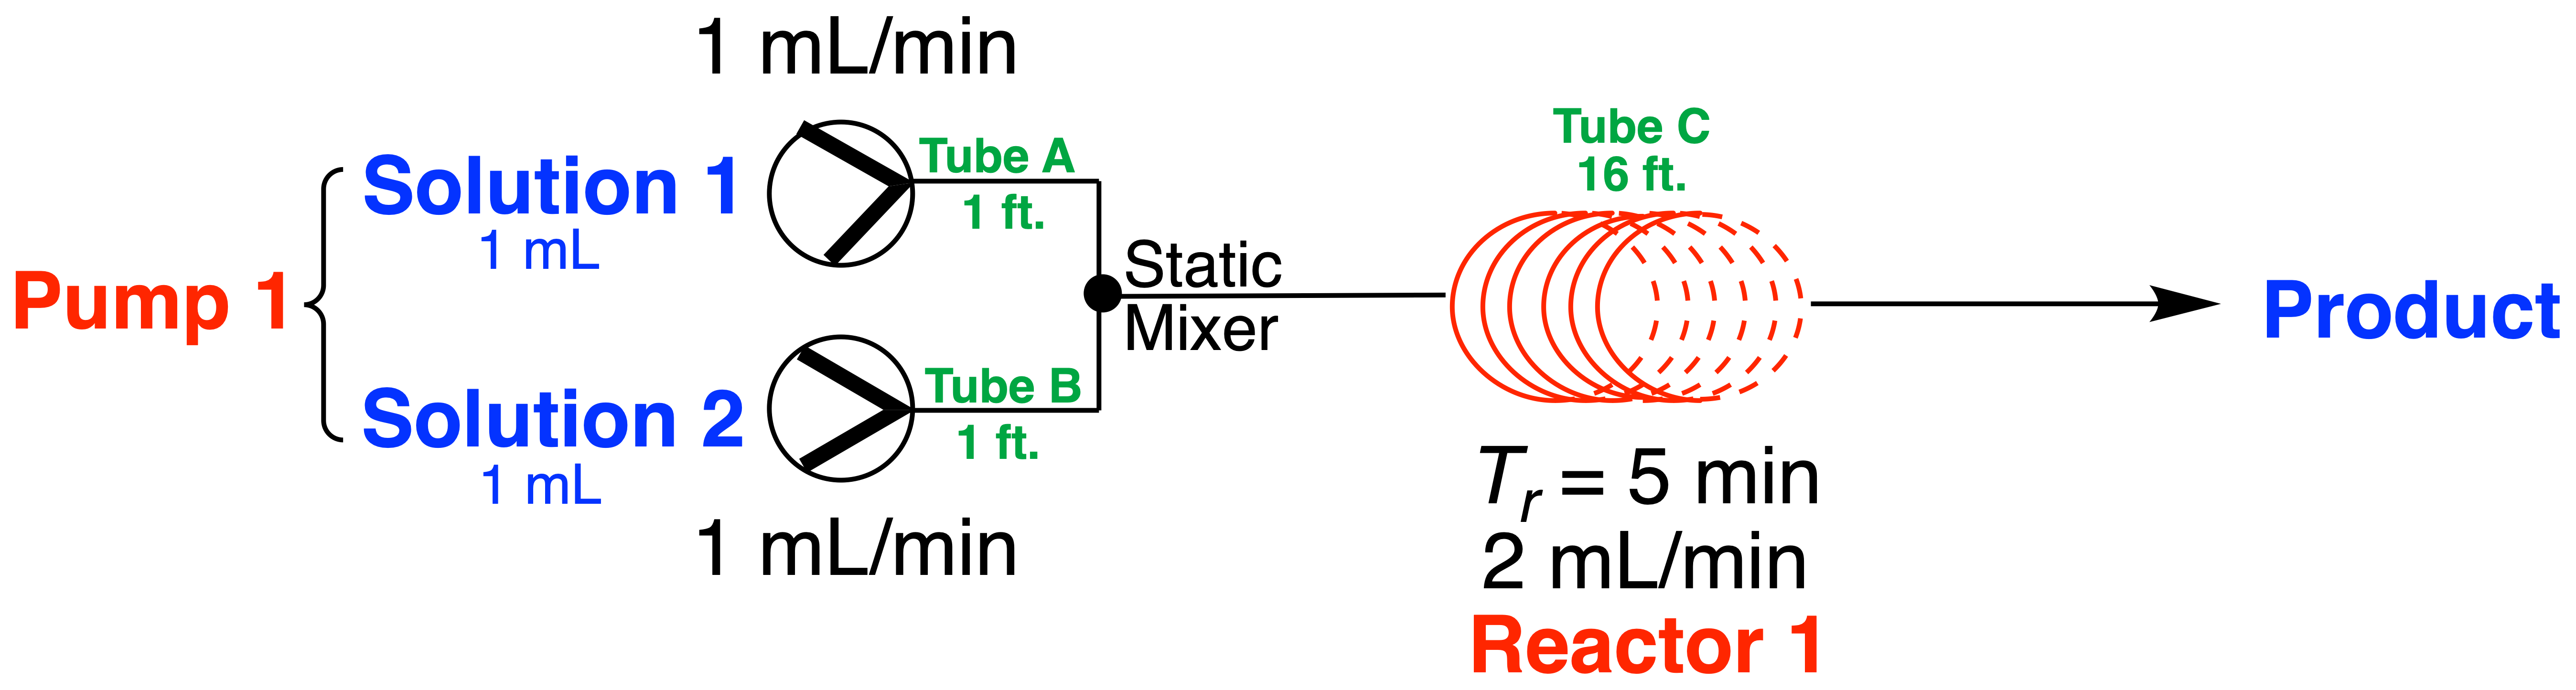

This block serves to identify the serial port number of your syringe pump. Make sure thepump is connected to the pi before running. On Macs, use the following command intemrinal to find serial port: ls /dev/tty.usb*. On Windows, open up Syringe Pump.ipynb and run command in last cell

In [19]:
pump_1 = HarvardSyringePump("2mL", "10mm", serial_port = '/dev/ttyACM0', name = "Pump 1")

### Syringes, Tubing, and Mixers

This block defines reagent vessels, edit the red text according to your reagents. Add syringes for the total number in your setup, plus one line for the product vessel, meaning the beaker or fraction collector you use. The product vessel will not influence the mechanical code, but will be included in the apparatus graphic and description.

In [20]:
#reagent vessels
## name is what will be shown in the diagram
syringe_1 = mw.Vessel("acceptor and donor and DCM", name = "acceptor and donor and DCM")
syringe_2 = mw.Vessel("TMSOTf and DCM", name = "TMSOTF and DCM")
product_vessel = mw.Vessel("glycosylated product", name = "glycosylated product")

#tubing
#Listed below are 3 of the most common tubing sizes.  

def small_tube(length):
    return mw.Tube(length = length, ID = "0.02 in", OD = "1/16 in", material = "PFA") 


starting = small_tube(length = "1 ft")
TMSOTf = small_tube(length = "50 ft")
reaction = small_tube(length = "1 ft")


#mixers
def Tmixer(name):
    return mw.TMixer(name = f'{name} Mixer')


T_1 = Tmixer("glycosylation")

### Apparatus

This block converts the tubing and syringes described above into a cohesive apparatus. Edit the three variables listed after each A.add to correspond to your setup. The first variable tellsthe code which pump to activate, the middle variable which syringe, and the third variable which tubing. Common errors in this block happen if you input the reagent names as the last variable instead of the tubing names. For example, in this code, the third variable is'starting', not 'DA.

In [21]:
A = mw.Apparatus("Glycosylation")

A.add(pump_1, syringe_1, starting)
A.add(pump_1, syringe_1, TMSOTf)
A.add(syringe_1, T_1, starting)
A.add(syringe_2, T_1, TMSOTf)
A.add(T_1, product_vessel, reaction)


A.visualize() #creates a diagram of the scheme
A.describe() #gives a detailed description of the apparatus (which components are connected by which tubing)

HarvardSyringePump Pump 1 was connected to a vessel containing acceptor and donor and DCM using PFA tubing (length 1 foot, ID 0.02 inch, OD 0.0625 inch). HarvardSyringePump Pump 1 was connected to a vessel containing acceptor and donor and DCM using PFA tubing (length 50 foot, ID 0.02 inch, OD 0.0625 inch). A vessel containing acceptor and donor and DCM was connected to TMixer glycosylation Mixer using PFA tubing (length 1 foot, ID 0.02 inch, OD 0.0625 inch). A vessel containing TMSOTf and DCM was connected to TMixer glycosylation Mixer using PFA tubing (length 50 foot, ID 0.02 inch, OD 0.0625 inch). TMixer glycosylation Mixer was connected to a vessel containing glycosylated product using PFA tubing (length 1 foot, ID 0.02 inch, OD 0.0625 inch). 

### Diagram

### Protocol

This is the part of the code that actually causes the syringe pumps to move. You will edit this depending on the flow rate of your reaction

In [22]:
P = mw.Protocol(A)

#Step 2
current = timedelta(seconds = 0)

#Step 1 
switch = timedelta(seconds = 45) 

#Step 3
pump_1_reagents = timedelta(minutes = 7)
P.add(pump_1, start = current,
              duration = pump_1_reagents, rate = "0.5mL/min")

#Step 4
current += pump_1_reagents + switch

#Step 5
flush = timedelta(minutes = 7)
P.add(pump_1, start = current,
              duration = flush, rate = "0.5mL/min")

current += flush


print(f'TOTAL TIME: {current}')
P.execute(confirm = True)

TOTAL TIME: 0:14:45


RuntimeError: HarvardSyringePump Pump 1 isn't valid. Got error: '[Errno 2] could not open port /dev/ttyACM0: [Errno 2] No such file or directory: '/dev/ttyACM0''.

### TLC Calculations

In [ ]:
# this cell doesn't need to be adjusted, simply run the cell and the press run
#method

solvent_tlc = input("Mobile phase solvent:")
stain = input ("Enter stain:")
UV_activity_information = input("Enter UV activity information:")

#data, all distances should be in cm
sample_1_distance = input("Enter distance moved by sample 1:")
sample_2_distance = input("Enter Distance moved by sample 2:")
solvent_distance = input("Enter distance moved by solvent:")

sample_1_distance = float(sample_1_distance)
sample_2_distance = float(sample_2_distance)
solvent_distance = float(solvent_distance)

RF_value_1 = sample_1_distance/solvent_distance
RF_value_2 = sample_2_distance/solvent_distance
RF_value_1 = round(RF_value_1, decimals = 4)
RF_value_2 = round(RF_value_2, decimals = 4)
print(RF_value_1)
print(RF_value_2)

### TLC/reaction images

You can insert an image by selecting the cell type as 'markdown' and then navigating to Edit > Insert Image. Run the cell to display the image

### Residence time calculations

This block calculates the time to reach each T mixture and the time to switch reagents. Timefor reagent to travel from syringe to first T mixture. Input your tubing length, l, flow rate, f, and syringe volume, v.

In [ ]:
l = 1 #in feet
f = 0.5 #in mL/min
v = 6 #in mL

cm = ID*2.54
r=cm/2
tubing=l*30.48
#converts length of tubing from feet to cm
volume=(3.14159265*(r*r)*tubing)
#volume of coil
time=round(60*(volume)/f, decimals =2)
print(f"The time to reach the first T mixer is", time, f"seconds")
left = round(v-volume, decimals = 2)
print(f"The volume left in each syringe after the given time is",left

#Time for reagent to travel from T mixture through coil aka the time t
#Input your tubing length, l and flow rate, f (so, if two syringes eac

l_2 = 50 #in feet
f_2 = 1 #in mL/min, combined total of 0.5 mL/min from each syringe

cm_2 = ID*2.54
r_2 = cm/2
tubing_2 = l_2*30.48
#converts length of tubing from feet to cm
volume_2 = (3.14159265*(r_2*r_2)*tubing_2)
#volume of coil
time_2 = round(time + 60 * (volume_2)/f_2, decimals = 2)
print(f"The residence time is", time_2, f"seconds")
left_2 = round(v - (volume + (volume_2/2)), decimals = 2)
#This should also be the time the second pump starts
print(f"The volume left in each syringe after the given time is", left

time_3 = round(((left_2/f)*60)+time+time_2,decimals=2)
print(f"It will take a total of",time_3,f"seconds to use the full vo
#It will take ____ seconds to use the full volume of each syringe

### NMR Data

Insert your jpeg file here. You can insert an image by selecting the cell type as 'markdown'and then navigating to Edit > Insert Image. Run the cell to display the image

### Additional Data and Notes

[For notes]

### Copyright information

Copyright <2023> NICOLA POHL
Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:
1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS “AS IS” AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
This code is based on Jupyter Notebooks.
Kluyver, T., Ragan-Kelley, B., Pérez, F., Granger, B.E., Bussonnier, M., Frederic, J., Kelley, K., Hamrick, J.B., Grout, J., Corlay, S., Ivanov, P., Avila, D., Abdalla, S., Willing, C., & Team, J.D. (2016). Jupyter Notebooks - a publishing format for reproducible computational workflows. International Conference on Electronic Publishing